# Policy Gradients

## Importing everything

In [1]:
import sys; sys.path.insert(0, '..')
import gym
from gym import wrappers
import tensorflow as tf
import numpy as np

## Model
### The Agent
This class is a representing a reinforcement learner and provides some convenient functionalities.

In [2]:
class Agent(object):
    '''Class for a reinforcement learner.

    Attributes
    ----------
    observations    :   tf.placeholder
                        Input port for currently observed environment. Shape is (1, 4)
    gradients   :   list
                    Negative gradients for the 4 trainable variables of the fully connected network
    grad_placeholders   :   list
                            `tf.placeholder`s for each of the trainable variables. Must be fed during
                            `train()`
    training_step   :   tf.op
                        Gradient application operation
    '''

    def __init__(self, learning_rate, **kwargs):
        '''Respected kwargs are

        Parameters
        ----------
        steps   :   int
                    Decay learning rate according to `exponential_decay` every `steps` steps
        decay   :   decay factor for `exponential_decay`
        learning_rate   :   base learning rate for `exponential_decay`
        '''

        ######################################
        #  Create the dynamic learning rate  #
        ######################################
        step_counter       = tf.Variable(0, trainable=False, dtype=tf.int32, name='step_counter')
        steps              = kwargs.get('steps', 100)
        decay              = kwargs.get('decay', 0.8)
        learning_rate      = tf.train.exponential_decay(learning_rate, step_counter, steps, decay)

        ############################################################################################
        #                                    Define the network                                    #
        ############################################################################################
        self.observations  = tf.placeholder(tf.float32, shape=[1, 4], name='observations')
        hidden_layer       = fully_connected(self.observations, 8, with_activation=True,
                                             activation=tf.nn.relu)
        probability        = fully_connected(hidden_layer, 1, with_activation=True,
                                             activation=tf.nn.sigmoid)
        complementary      = tf.subtract(1.0, probability)
        output             = tf.concat([probability, complementary], 1, name='action_probabilities')
        log_likelihoods    = tf.log(output)
        self.action        = tf.multinomial(log_likelihoods, num_samples=1)[0][0]
        log_likelihood     = log_likelihoods[:, tf.to_int32(self.action)]

        optimizer = tf.train.AdamOptimizer(learning_rate)
        grads_and_vars = optimizer.compute_gradients(log_likelihood)
        self.gradients = [grad * -1 for (grad, _) in grads_and_vars]

        # Gradients must be fed for training
        self.grad_placeholders = []
        for i, gradient in enumerate(self.gradients):
            self.grad_placeholders.append(tf.placeholder(tf.float32, gradient.shape,
                                                         name='gradient_{}'.format(i)))
        self.grad_dummies = [np.zeros(grad.shape) for grad in self.grad_placeholders]

        tvars = tf.trainable_variables()
        self.training_step = optimizer.apply_gradients(zip(self.grad_placeholders, tvars),
                                                       global_step=step_counter)


    def get_action(self, observation, session):
        '''Retrieve an action for a given set of observations.

        Parameters
        ----------
        observation :   np.ndarray
                        Array of shape (4,) or (1, 4), representing the current observation
        session :   tf.Session
                    Session to run ops in

        Returns
        -------
        int
            0 or 1, depending on the action the network recommends
        '''
        # ensure input has 2 dims
        if observation.ndim == 1:
            observation = observation[np.newaxis, :]

        feed_dict = {self.observations: observation}
        # we don't actually need the gradients
        feed_dict.update({p: grad for (p, grad) in zip(self.grad_placeholders, self.grad_dummies)})

        return session.run([self.action] + self.gradients, feed_dict=feed_dict)

    def train(self, discounted_gradients, session):
        '''Apply discounted gradients computed over one episode.

        Parameters
        ----------
        discounted_gradients    :   list
                                    List of np.ndarrays with modified gradients for each of the 4
                                    trainable variables
        session :   tf.Session
                    Session to run ops in
        '''
        feed_dict = {self.observations: np.zeros((1, 4), np.float32)}
        feed_dict.update({p: grad for (p, grad) in zip(self.grad_placeholders, discounted_gradients)})

        session.run([self.training_step], feed_dict=feed_dict)

### Fully connected FFNN Helper

In [3]:
fc_n = 0
def fully_connected(input, n_out, with_activation=False, activation=tf.nn.tanh,
        use_bias=True):
    '''Create a fully connected layer with fixed activation function and variable
    initialisation. The activation function is ``tf.nn.tanh`` and variables are
    initialised from a truncated normal distribution with an stddev of 0.1

    Parameters
    ----------
    input   :   tf.Variable
                Input to the layer
    n_out   :   int
                Number of neurons in the layer
    with_activation :   bool
                        Return activation or drive (useful when planning to use
                        ``softmax_cross_entropy_with_logits`` which requires
                        unscaled logits)


    Returns
    -------
    tf.Variable
            The variable representing the layer activation
    '''
    global fc_n
    fc_n += 1
    with tf.variable_scope('fully%d' % fc_n):
        (fan_in, fan_out) = (input.shape[-1].value, n_out)
        if activation == tf.nn.tanh:
            init_W = tf.random_normal_initializer(stddev=fan_in ** (-0.5))
        elif activation == tf.nn.relu:
            init_W = tf.random_normal_initializer(stddev=2 / fan_in)
        else:
            init_W = tf.random_normal_initializer()
        init_b = tf.constant_initializer(0.1)
        W = tf.get_variable(
                'weights',
                initializer=init_W,
                shape=(input.shape[-1], n_out), # the last dim of the input
               dtype=tf.float32                 # is the 1st dim of the weights
            )
        if use_bias:
            bias = tf.get_variable('bias', initializer=init_b, shape=(n_out,))
        if use_bias:
            drive = tf.matmul(input, W) + bias
        else:
            drive = tf.matmul(input, W)
        if with_activation:
            return activation(drive)
        else:
            return drive

## Discounted Rewards and Gradients
These two functions will be used to compute the discounted rewards and based on those weigh the gradients accordingly.

In [4]:
def discounted_rewards(rewards_per_time, discount_factor):
    '''Calculate the discounted rewards over a time series of rewards.

    Parameters
    ----------
    rewards_per_time    :   list or np.ndarray
                            List of rewards observed for each time step
    Returns
    -------
    np.ndarray
        Discounted rewards

    '''
    if not isinstance(rewards_per_time, np.ndarray):
        rewards_per_time = np.array(rewards_per_time)

    T = len(rewards_per_time)
    # create vector with all elems set to factor and power it with [0,...,T-1]
    factors = np.power(np.full((T,), discount_factor, np.float32), np.arange(T))
    discounted_rewards = [np.dot(rewards_per_time[t:], factors[:T-t]) for t in range(T)]
    mu, std = np.mean(discounted_rewards), np.std(discounted_rewards)
    discounted_rewards = ((discounted_rewards - mu) / std)
    return discounted_rewards


def discounted_gradients(grads, discounted_rewards):
    '''Discount gradients by multiplying with rewards

    Parameters
    ----------
    grads   :   list
                Raw gradients
    discounted_rewards  :   list or np.ndarray
                            Reward factors as returned by `discounted_rewards()`

    Returns
    -------
    np.ndarray
        Discounted gradients

    '''
    discounted_gradients = []
    # each time step is a list of arrays, so multiply each of those with the time step's discount
    # factor'
    for t in range(len(grads)):
        discounted_gradients.append([g * discounted_rewards[t] for g in grads[t]])

    return discounted_gradients

## Run the model
### Define the parameters accordingly.

In [5]:
episodes      = 1000  # Number of episodes
iterations    = 200   # Number of steps per episode
render_step   = 1000  # Render frame every r steps
batch_size    = 1     # Average over several episodes
learning_rate = 0.01  # Learning rate for Adam
gamma         = 0.95  # Discount factor
plot          = True  # Display a dynamic plot.

### Define a little bar thingy for terminal peepz

In [6]:
def progress_string(reward, iters, width=100):
    '''Create a fun bar to visualise learner performance'''

    done_bar = int(width * reward / iters) * '█'
    spaces = (width - len(done_bar)) * ' '
    return 'Cumulative reward: [{}{}]'.format(done_bar, spaces)

### Train the model and visualize the results

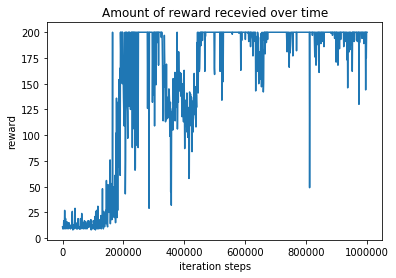

In [7]:
env = gym.make('CartPole-v0')

env.spec.max_episode_steps = iterations
summed_gradient_buffer     = []

if plot:
    from matplotlib import pyplot as plt
    fig = plt.figure()
    axes = fig.add_subplot(111)
    graph, = axes.plot([], [])
    axes.set_title('Amount of reward recevied over time')
    axes.set_xlabel('iteration steps')
    axes.set_ylabel('reward')
    #plt.ion()
    #plt.show()

agent = Agent(learning_rate, steps=episodes // 5)

with tf.Session() as session:
    session.run(tf.global_variables_initializer())

    for episode in range(episodes):
        gradient_buffer = []
        summed_gradient_buffer = []
        reward_buffer   = []
        observation     = env.reset()
        step_count      = 0
        done = False

        while not done:
            act, *grads = agent.get_action(observation, session)

            if episode * step_count % render_step == 0:
                env.render()
            step_count += 1

            observation, reward, done, info = env.step(act)
            reward_buffer.append(reward)
            gradient_buffer.append(grads)

            if done:
                # print(progress_string(len(reward_buffer), iterations))
                if plot:
                    graph.set_xdata(np.append(graph.get_xdata(), episode * episodes + step_count))
                    graph.set_ydata(np.append(graph.get_ydata(), len(reward_buffer)))
                    axes.relim()
                    axes.autoscale_view()
                    #plt.draw()
                    #plt.pause(0.01)


        ##################
        #  Episode done  #
        ##################
        rewards      = discounted_rewards(reward_buffer, gamma)
        gradients    = discounted_gradients(gradient_buffer, rewards)
        gradient_sum = np.sum(np.array(gradients), 0)
        summed_gradient_buffer.append(gradient_sum)
        if (episode + 1) % batch_size == 0:
            for g in summed_gradient_buffer:
                agent.train(g, session)
            
    if plot:
        plt.show()